In [ ]:
pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 31.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pennylane as qml

In [ ]:
# Define the QLSTM model class
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        self.fc = torch.nn.Linear(self.hidden_size, 1)  # Final fully connected layer

    def forward(self, x, init_states=None):
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]

            v_t = torch.cat((h_t, x_t), dim=1)

            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        h_t = hidden_seq[:, -1, :]  # Take the output of the last time step
        output = self.fc(h_t)  # Pass through final fully connected layer to get single output

        return output.squeeze(), (h_t, c_t)

In [ ]:
# Load dataset
df = pd.read_csv('/content/typeII_AGN_metadata.csv')

# Define target and features
target = 'log_bh_mass'
features = [
    'h_beta_flux', 'h_beta_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
    'h_alpha_flux', 'h_alpha_flux_err', 'nii_6584_flux', 'nii_6584_flux_err',
    'log_stellar_sigma', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
    'psfMag_z', 'psfMagErr_u', 'psfMagErr_g', 'psfMagErr_r', 'psfMagErr_i',
    'psfMagErr_z', 'mendel_logM_p50', 'mendel_logM_p16', 'mendel_logM_p84',
    'mendel_logMt_p50', 'mendel_logMt_p16', 'mendel_logMt_p84',
    'mendel_logMb_p50', 'mendel_logMb_p16', 'mendel_logMb_p84',
    'mendel_logMd_p50', 'mendel_logMd_p16', 'mendel_logMd_p84',
    'simard_b_t_g', 'simard_e_b_t_g', 'simard_b_t_r', 'simard_e_b_t_r',
    'simard_Rhlg', 'simard_Rhlr', 'simard_Rchl_g', 'simard_Rchl_r',
    'simard_Re', 'simard_e_Re', 'simard_e', 'simard_e_e', 'simard_nb',
    'simard_e_nb', 'simard_PpS', 'simard_Pn4'
]

# Handling Missing Values
df.fillna(df.mean(), inplace=True)

# Features and target arrays
X = df[features].values
y = df[target].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reduce the number of features to 4 using PCA
pca = PCA(n_components=4)
X = pca.fit_transform(X)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define QLSTM parameters
input_size = X_train.shape[1]  # After PCA reduction, input_size should be 4
hidden_size = 32
n_qubits = 4
n_qlayers = 1

# Initialize the QLSTM model
model = QLSTM(input_size=input_size, hidden_size=hidden_size, n_qubits=n_qubits, n_qlayers=n_qlayers)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Train the model
for epoch in range(3):
    model.train()
    total_loss = 0
    for i in range(X_train_tensor.size(0)):
        optimizer.zero_grad()
        single_output, _ = model(X_train_tensor[i].unsqueeze(0).unsqueeze(0))
        single_output = single_output.squeeze()  # Ensure output is a scalar
        target = y_train_tensor[i]  # Target is already a scalar

        loss = criterion(single_output, target)  # Calculate the loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print the current epoch and average loss
    print(f"Epoch [{epoch+1}/3], Loss: {total_loss / X_train_tensor.size(0):.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    pred = []
    for i in range(X_test_tensor.size(0)):
        single_pred, _ = model(X_test_tensor[i].unsqueeze(0).unsqueeze(0))
        pred.append(single_pred.item())

# Convert list of predictions to a NumPy array
pred = np.array(pred)

Epoch [1/3], Loss: 2.6262
Epoch [2/3], Loss: 0.3208
Epoch [3/3], Loss: 0.3191


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    pred = []
    for i in range(X_test_tensor.size(0)):
        single_pred, _ = model(X_test_tensor[i].unsqueeze(0).unsqueeze(0))
        pred.append(single_pred.item())

# Convert list of predictions to a NumPy array
pred = np.array(pred)

In [ ]:
# Calculate error metrics
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
mse = mean_squared_error(y_test, pred)

# Accuracy by error (1-error/range)*100
y_range = y.max() - y.min()
mae_accuracy = (1 - mae/y_range) * 100
rmse_accuracy = (1 - rmse/y_range) * 100
mse_accuracy = (1 - mse/y_range) * 100

In [ ]:
# Print error metrics
print(f'R²: {r2}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MSE: {mse}')

print(f'MAE Accuracy: {mae_accuracy}%')
print(f'RMSE Accuracy: {rmse_accuracy}%')
print(f'MSE Accuracy: {mse_accuracy}%')

R²: 0.2349900457688684
MAE: 0.44908019248066305
RMSE: 0.568170348983628
MSE: 0.32281754546417757
MAE Accuracy: 91.0936176742337%
RMSE Accuracy: 88.73176230227489%
MSE Accuracy: 93.59772145485306%


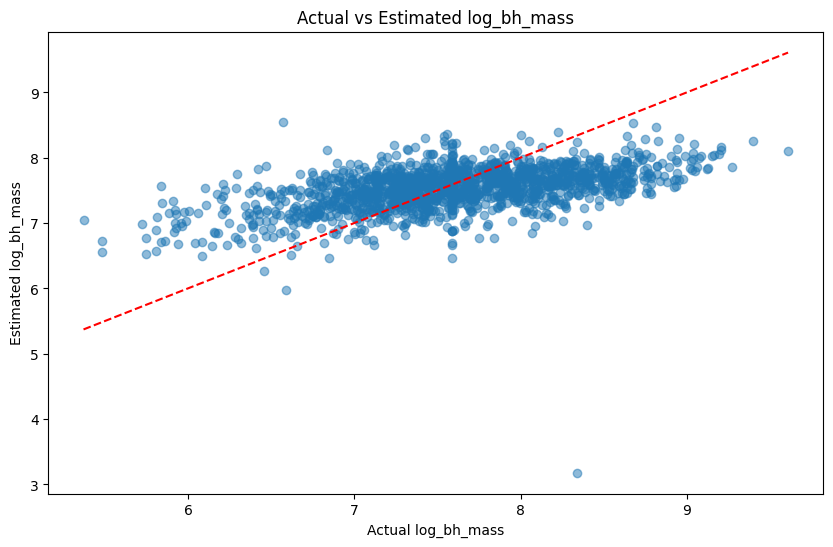

In [ ]:
# Plot actual vs estimated log_bh_mass
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual log_bh_mass')
plt.ylabel('Estimated log_bh_mass')
plt.title('Actual vs Estimated log_bh_mass')
plt.show()